## Building a router agent to classify text/reviews and draft up a response

In [ ]:
# built-in libraries
import os
from typing import Literal, TypedDict,  Any, Optional, Tuple, List, Dict, Union

# langgraph libraries
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.graph import  MermaidDrawMethod

# misc libraries
from pydantic import Field
from IPython.display import Image
#from decouple import config
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from tqdm import tqdm
from sklearn.metrics import f1_score




Watsonx credentials

In [9]:
WX_API_KEY = os.getenv("WX_API_KEY")
WX_PROJECT_ID_RAG = os.getenv("WX_PROJECT_ID_RAG")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

Getting our LLM caller class - Defined in LLM.py

In [ ]:

model = LLMCaller(
    api_key=WX_API_KEY,
    project_id=WX_PROJECT_ID_RAG,
    api_url=WX_API_URL,
    model_id="watsonx/ibm/granite-3-8b-instruct",
    params={
        GenParams.TEMPERATURE: 0.3,
        GenParams.MAX_NEW_TOKENS: 70,
    }
)

Frist we define the STATE, this contains the attributes we cant populated when we run the system

In [29]:
# Define your state type
class ReviewState(TypedDict):
    review_text: str
    emotion: [str]
    draft_reply: [str]
    verbose: bool = False

Creating the nodes of the system

In [ ]:
def read_review(state: ReviewState) -> dict:
    """Reviewbot loads and logs the incoming customer review"""
    review = state["review_text"]
    if state["verbose"]:
        print(f"Reviewbot received review: “{review}”")
    # no changes to state here
    return {}


def classify_emotion(state: ReviewState) -> dict:
    """Use the LLM to pick one or more Ekman emotions"""
    text = state["review_text"]
    prompt = f"""you an expert in decphiering emotions from texts, Your job is to read a text/review and selects one or more of Ekman's six basic emotions (anger, disgust, fear, joy, sadness, surprise, or neutral) which best fit the review/text.
    
Review:
\"\"\"{text}\"\"\"

Respond **only** in JSON with the below field:
  • emotion: "anger","disgust","fear","joy","sadness","surprise" or "neutral"  
"""
    # build a structured response model
    response_model = model.create_response_model(
        "EmotionClassification",
        {
            "emotion": (
                Literal["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"],
                Field(description="The chosen emotion")
            ),
        }
    )
    resp = model.invoke(prompt, response_model=response_model)
    return {
        "emotion": resp.emotion,
    }


def draft_response(state: ReviewState) -> dict:
    """Draft an empathetic reply based on the classified emotion"""
    text = state["review_text"]
    emo  = state["emotion"]
    prompt = f"""A customer expresses **{emo}** in this review:
\"\"\"{text}\"\"\"

Write a concise, empathetic customer-service response that:
  - Acknowledges their {emo},
  - Addresses any concerns they raise,
  - Invites further dialogue if needed.
"""
    resp = model.invoke(prompt)
    return {"draft_reply": resp.answer}


def notify_user(state: ReviewState) -> dict:
    """Present the final draft back to the support agent"""
    if state["verbose"]:
        print("\n" + "="*40)
        print(f"Review classified as: {state['emotion']}")
        print("Draft response:")
        print(state["draft_reply"])
        print("="*40 + "\n")
    return {}


Creating the conditional edge

In [16]:
def route_review(state: ReviewState) -> str:
    """Route to the next step based on the detected emotion."""
    # We always want to draft a response—
    # so we unconditionally return the label that points at the DraftReply node.
    return "to_draft"


### Creating Graph of the system

In [40]:
# Create the graph
review_graph = StateGraph(ReviewState)  # Initialize with your ReviewState

# Add nodes
review_graph.add_node("read review",       read_review)
review_graph.add_node("classify emotion",  classify_emotion)
review_graph.add_node("draft response",    draft_response)

# Wire up the edges
# 1) START → read_review
review_graph.add_edge(START, "read review")

# 2) read_review → classify_emotion
review_graph.add_edge("read review", "classify emotion")

# 3) classify_emotion → route_review
review_graph.add_edge("classify emotion", "draft response")

review_graph.add_edge("draft response", END)

compiled_graph = review_graph.compile()

Print the graph

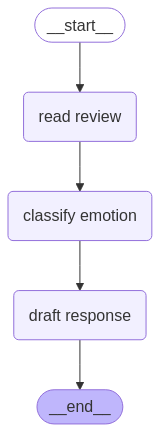

In [41]:
Image(compiled_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API))